In [1]:
# drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/madhueb/DIS_project1.git
import os
os.chdir('./DIS_project1')

Cloning into 'DIS_project1'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 240 (delta 133), reused 173 (delta 76), pack-reused 0 (from 0)
Receiving objects: 100% (240/240), 44.53 KiB | 14.84 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [3]:
import pandas as pd

from accelerate import Accelerator

In [4]:
from config.config import CONFIG

In [5]:
from src.models.embedder import Embedder
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model'], use_fast=CONFIG['tokenizer_use_fast'])
embedder = AutoModel.from_pretrained(CONFIG['model']).to(CONFIG['device'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [9]:
train_df = pd.read_csv(CONFIG['train_path'])
dev_df = pd.read_csv(CONFIG['dev_path'])

In [10]:
from src.models.utils import query_embedding

train_df['query_embed'] = train_df['query'].apply(lambda x: query_embedding(x, embedder, tokenizer, CONFIG))
dev_df['query_embed'] = dev_df['query'].apply(lambda x: query_embedding(x, embedder, tokenizer, CONFIG))

In [11]:
def upsample_data(df):
    # Upsample the data to balance across languages
    lang_counts = df['lang'].value_counts()
    max_count = lang_counts.max()
    upsampled_dfs = []
    for lang in lang_counts.index:
        lang_df = df[df['lang'] == lang]
        upsampled_df = lang_df.sample(max_count - lang_counts[lang], replace=True)
        upsampled_dfs.append(pd.concat([lang_df, upsampled_df]))
    return pd.concat(upsampled_dfs)

In [12]:
train_df = upsample_data(train_df)

In [13]:

# save with pickle
import pickle

with open(CONFIG['train_emb_path'], 'wb') as f:
    pickle.dump(train_df, f)

with open(CONFIG['dev_emb_path'], 'wb') as f:
    pickle.dump(dev_df, f)

In [15]:
train_df.head()

,query_id,query,positive_docs,negative_docs,lang,query_embed
0,q-en-425512,What is the connection between AAA and Lucha U...,doc-en-798457,"['doc-en-810925', 'doc-en-634020', 'doc-en-143...",en,"[[0.014331106, -0.3063315, -0.04876322, 0.1574..."
1,q-en-16636,What is the medical use of iloperidone?,doc-en-121692,"['doc-en-177976', 'doc-en-700330', 'doc-en-567...",en,"[[0.15212916, -0.3245323, 0.06479909, 0.128165..."
2,q-en-282671,Who was the provisional administrator in 1940?,doc-en-750259,"['doc-en-805362', 'doc-en-413387', 'doc-en-827...",en,"[[0.07762754, -0.22635265, 0.07437346, 0.14042..."
3,q-en-216614,What was the critical reception of the film se...,doc-en-703883,"['doc-en-685958', 'doc-en-84060', 'doc-en-2046...",en,"[[0.11140423, -0.18713488, 0.20843916, 0.08391..."
4,q-en-156120,What was the main Spanish record of the year i...,doc-en-648393,"['doc-en-4307', 'doc-en-761696', 'doc-en-79426...",en,"[[0.07236019, -0.2692672, 0.07602634, 0.132853..."


In [6]:

# load with pickle
import pickle

with open(CONFIG['train_emb_path'], 'rb') as f:
    train_df = pickle.load(f)

with open(CONFIG['dev_emb_path'], 'rb') as f:
    dev_df = pickle.load(f)

In [6]:
import pickle

# load document embeddings
with open(CONFIG['doc_embeds_path'], 'rb') as f:
    doc_embeds = pickle.load(f)

In [8]:
from src.dataloaders.utils import get_train_val_dataloaders

train_dl, val_dl = get_train_val_dataloaders(CONFIG, train_df, dev_df, doc_embeds)

In [9]:
accelerator = Accelerator(gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'])

In [10]:
from src.training.trainner import Trainer
from src.models.dpr import DPRModel

embed_size = embedder.config.hidden_size
model = DPRModel(embed_size).to(CONFIG['device'])
trainer = Trainer(model, (train_dl, val_dl), CONFIG, accelerator)

In [11]:
trainer.train()

Training...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.5541601336070467
valid loss: 1.3232424698557173




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.4968903675351823
valid loss: 1.303489569255284




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.451951813030243
valid loss: 1.29542158637728




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.4100598060744147
valid loss: 1.291313750743866




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.385958423560006
valid loss: 1.2922222467831204




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.423968505573273
valid loss: 1.2961364027432034




  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.3857920086996898
valid loss: 1.2900170530591692




In [12]:
losses_df = pd.DataFrame({'epoch':list(range(1, CONFIG['epochs'] + 1)),
                          'train_loss':trainer.train_losses,
                          'val_loss': trainer.val_losses
                         })
losses_df.to_csv(CONFIG['losses_path'], index=False)

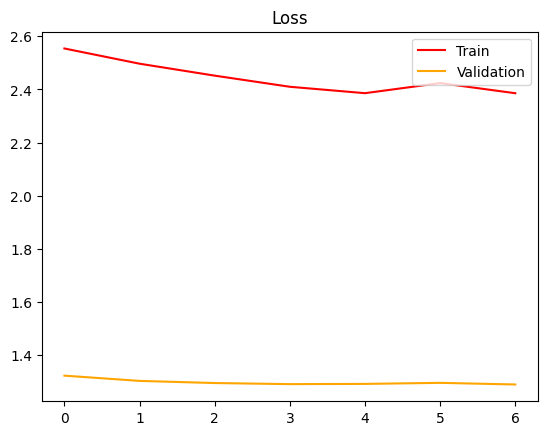

In [13]:
from matplotlib import pyplot as plt

plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [8]:
from src.models.encoder import Encoder
import torch

embed_size = embedder.config.hidden_size
doc_encoder = Encoder(embed_size).to(CONFIG['device'])
doc_encoder.load_state_dict(torch.load(f"{CONFIG['load_path']}/doc_encoder.pth"))

<ipython-input-8-a868b92d225f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  doc_encoder.load_state_dict(torch.load(f"{CONFIG['load_path']}/doc_encoder.pth"))


<All keys matched successfully>

In [9]:
from src.dataloaders.vec_dataset import VecDataset

docids = []
langs = []
vecs = []
for docid, embed_dict in doc_embeds.items():
    for embed in embed_dict['embeds']:
        docids.append(docid)
        langs.append(embed_dict['lang'])
        vecs.append(embed)

vec_ds = VecDataset(docids, langs, vecs)

In [11]:
from tqdm import tqdm

vec_dataloader = torch.utils.data.DataLoader(vec_ds, batch_size=256, collate_fn=vec_ds.collate_fn, shuffle=False, num_workers=4)

doc_encodes = []
doc_ids = []
doc_langs = []

with torch.no_grad():
    for batch in tqdm(vec_dataloader, desc="Encoding documents"):
        doc_ids.extend(batch['q_id'])
        doc_langs.extend(batch['lang'])
        doc_encodes.extend([doc_encode for doc_encode in doc_encoder(batch['vec'].to(CONFIG['device'])).cpu().numpy()])


Encoding documents:   0%|          | 0/20187 [00:00<?, ?it/s]/content/DIS_project1/src/dataloaders/vec_dataset.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  vecs = torch.tensor([sample["vec"] for sample in batch], dtype=torch.float32)
/content/DIS_project1/src/dataloaders/vec_dataset.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  vecs = torch.tensor([sample["vec"] for sample in batch], dtype=torch.float32)
/content/DIS_project1/src/dataloaders/vec_dataset.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consi

In [12]:
from tqdm import tqdm

encode_dict = {}

for docid, lang, encode_chunk in tqdm(zip(doc_ids, doc_langs, doc_encodes), desc="Creating encode dictionary"):
    if docid not in encode_dict:
        encode_dict[docid] = {'lang': lang, 'encodes': []}
    encode_dict[docid]['encodes'].append(encode_chunk)


Creating encode dictionary: 5167831it [00:05, 1001926.72it/s]


In [14]:
print(len(encode_dict), len(doc_ids), len(doc_langs), len(doc_encodes))

268022 5167831 5167831 5167831


In [15]:
import pickle

with open(CONFIG['doc_encodes_path'], 'wb') as f:
    pickle.dump(encode_dict, f)